# Introduction to PyMC
PyMC is an open-source probabilistic programming library in Python, tailored for constructing and estimating Bayesian models. By leveraging PyTensor, PyMC enables efficient computation through automatic differentiation and dynamic compilation to various computational backends, including C, JAX, and Numba, thereby optimizing performance across diverse hardware architectures.

The library offers an intuitive and expressive syntax that closely mirrors the natural mathematical notation used in statistical modeling, facilitating the seamless translation of theoretical models into executable code. This design choice enhances readability and maintainability, allowing practitioners to focus on model development without being encumbered by low-level implementation details.

PyMC incorporates state-of-the-art inference algorithms, notably the No-U-Turn Sampler (NUTS), an adaptive variant of Hamiltonian Monte Carlo (HMC), which excels in sampling from complex, high-dimensional posterior distributions. Additionally, it supports variational inference methods, providing flexibility in choosing the most appropriate inference technique based on model requirements and computational considerations.

Beyond its core modeling and inference capabilities, PyMC integrates seamlessly with ArviZ, a library dedicated to exploratory analysis of Bayesian models. This integration facilitates comprehensive model checking, diagnostics, and visualization, thereby enhancing the robustness and transparency of statistical analyses.

The versatility of PyMC extends to a wide array of applications, encompassing generalized hierarchical linear regression, time series analysis, ordinary differential equation modeling, and non-parametric approaches such as Gaussian processes. Its adaptability and comprehensive feature set make it an invaluable tool for addressing complex statistical modeling challenges across various scientific and engineering disciplines.

For those interested in exploring PyMC further, the official documentation provides extensive resources, including tutorials and example notebooks, to assist users in effectively applying the library to their specific modeling needs.  

## PyMC Basics: Models and Random Variables
In order to get the most out of PyMC, we need to learn about its basic building blocks: models and random variables.

The examples below are inspired and adapted (and sometimes just copied) from the excellent [PyMC documentation](https://www.pymc.io/welcome.html).

In [1]:
import arviz as az
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f"Using PyMC version: {pm.__version__}")

Using PyMC version: 5.21.2


The line above should print something like `5.19.1`.

Now, let's generate some data. We'll draw 100 observations from a Normal random variable.

In [3]:
rng = np.random.default_rng(42)
data = rng.standard_normal(500)
print(f"Observed data with mean {np.mean(data)} and sd {np.std(data)}")

Observed data with mean -0.013126150466933863 and sd 0.9589737047166969


In order to use PyMC, we need to create a probabilistic model and populate it with free random variables and observed variables.

We create a model by using the context manager `with`: every random variable defined within the context manager will be associated with the model.

Below, we create a free random variable that will be the average of the observed data we have just generated. Then, we'll try and infer the distribution of the average.

In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=data)

Let's check out the random variables.

In [5]:
model.basic_RVs

[mu, obs]

In [6]:
model.free_RVs

[mu]

In [7]:
model.observed_RVs

[obs]

We have:
- one free random variable, whose distribution can be estimated by the sampling process
- one observed random variable (the data)

We will see other ways of introducing data later.

Now, let's check out the variables.

## Variable transformation
When defining a model, you can combine several variables and deterministic transformation, using standard python operators.

In [8]:
with pm.Model() as model:
    x = pm.Normal("x", mu=0, sigma=1)
    y = pm.Gamma("y", alpha=1, beta=1)
    plus_2 = x + 2
    summed = x + y
    squared = x**2

However, the transformed variables are not saved when inference is run. In order to save them, you need to use a data container, as in the following cells.

In [9]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    plus_2 = pm.Deterministic("x plus 2", x + 2)

In order to use higher-order variables, you can exploit the `dims` parameter of each random variable.

In [10]:
coords = {"cities": ["Santiago", "Mumbai", "Tokyo"]}
with pm.Model(coords=coords) as model:
    x = pm.Normal("x", mu=0, sigma=1, dims="cities")
    y = x[0] * x[1]

## Inference

Now that we know how to populate models, let's try and draw some inference.

In [11]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=1, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    posterior_samples = pm.sample(random_seed=rng)
    prior_samples = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Output()

Oversimplifying, the sampling process estimates the distribution of unobserved variables by running multiple Markov chains whose value distributions converge to the posterior distribution of the unobserved variables.

The sampling algorithms can be complicated, but PyMC will handle the complexity for you.

Then, we can exploit the integration with arviz to visualize the distributions.

First, we'll visualize the prior distributions.

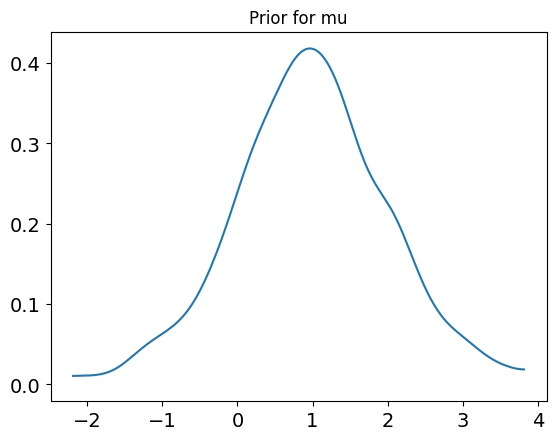

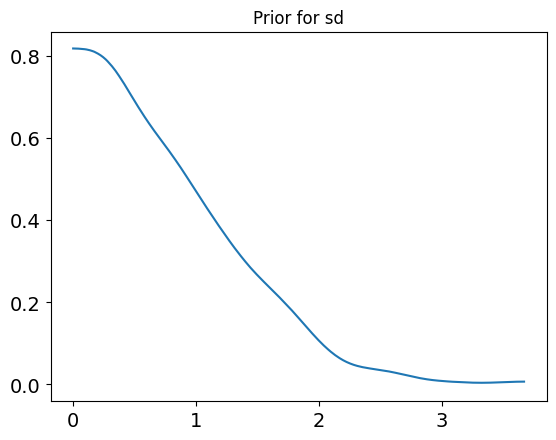

In [12]:
for var in ["mu", "sd"]:
    az.plot_dist(prior_samples.prior[var])
    plt.title(f"Prior for {var}")
    plt.show()

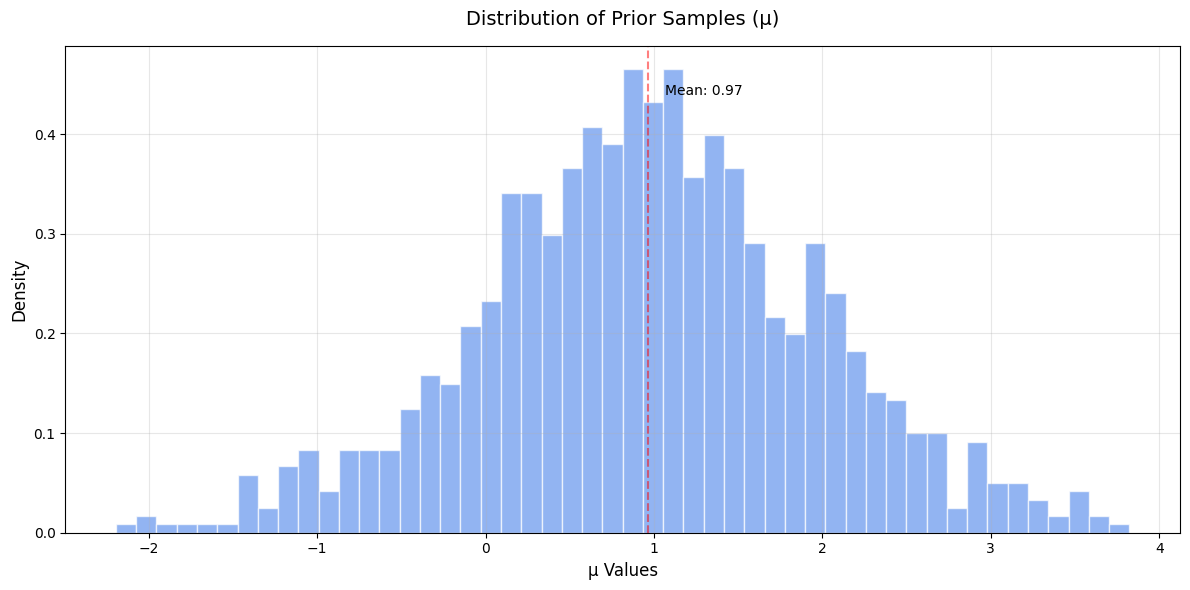

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(
    np.array(prior_samples.prior["mu"][0, :]),
    bins=50,
    color="cornflowerblue",
    alpha=0.7,
    edgecolor="white",
    density=True,
)

plt.grid(True, alpha=0.3)
plt.title("Distribution of Prior Samples (μ)", fontsize=14, pad=15)
plt.xlabel("μ Values", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Add mean line and annotation
mean_mu = np.mean(prior_samples.prior["mu"][0, :])
plt.axvline(mean_mu, color="red", linestyle="--", alpha=0.5)
plt.text(mean_mu * 1.1, plt.gca().get_ylim()[1] * 0.9, f"Mean: {mean_mu:.2f}", fontsize=10)

plt.tight_layout()
plt.show()

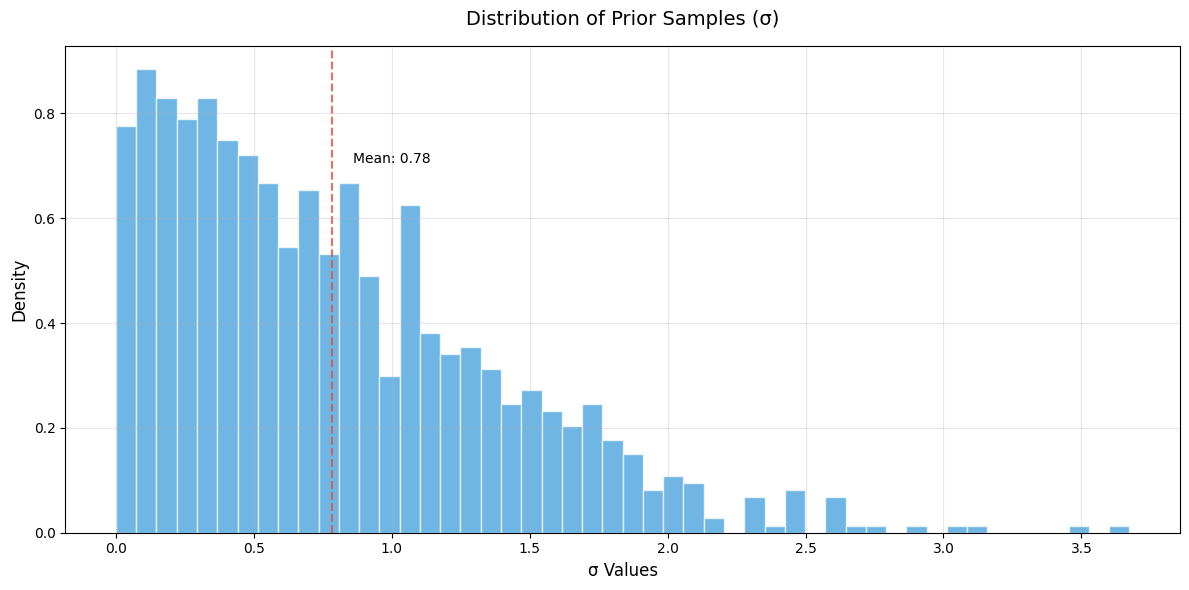

In [14]:
plt.figure(figsize=(12, 6))

plt.hist(
    np.array(prior_samples.prior["sd"][0, :]),
    bins=50,
    color="#3498db",
    alpha=0.7,
    edgecolor="white",
    density=True,
    label="σ",
)

mean_sd = np.mean(np.array(prior_samples.prior["sd"][0, :]))
plt.axvline(mean_sd, color="#e74c3c", linestyle="--", label=f"Mean: {mean_sd:.2f}", alpha=0.8)
plt.text(mean_sd * 1.1, mean_sd * 0.9, f"Mean: {mean_sd:.2f}", fontsize=10)

plt.grid(True, alpha=0.3)
plt.title("Distribution of Prior Samples (σ)", fontsize=14, pad=15)
plt.xlabel("σ Values", fontsize=12)
plt.ylabel("Density", fontsize=12)

plt.tight_layout()
plt.show()

Then, we check out the sampling process and the posterior distributions.

There are no spikes or divergences in the chains, so the inference process was smooth.

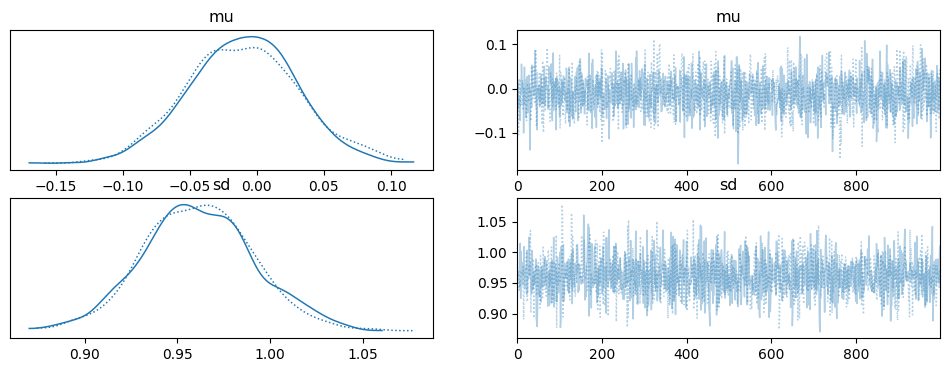

In [15]:
az.plot_trace(posterior_samples);

Finally, we check out a summary and a more detailed plot for the posteriors.

In [16]:
az.summary(posterior_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.011,0.041,-0.088,0.066,0.001,0.001,1975.0,1391.0,1.0
sd,0.962,0.030,0.906,1.022,0.001,0.001,2200.0,1349.0,1.0


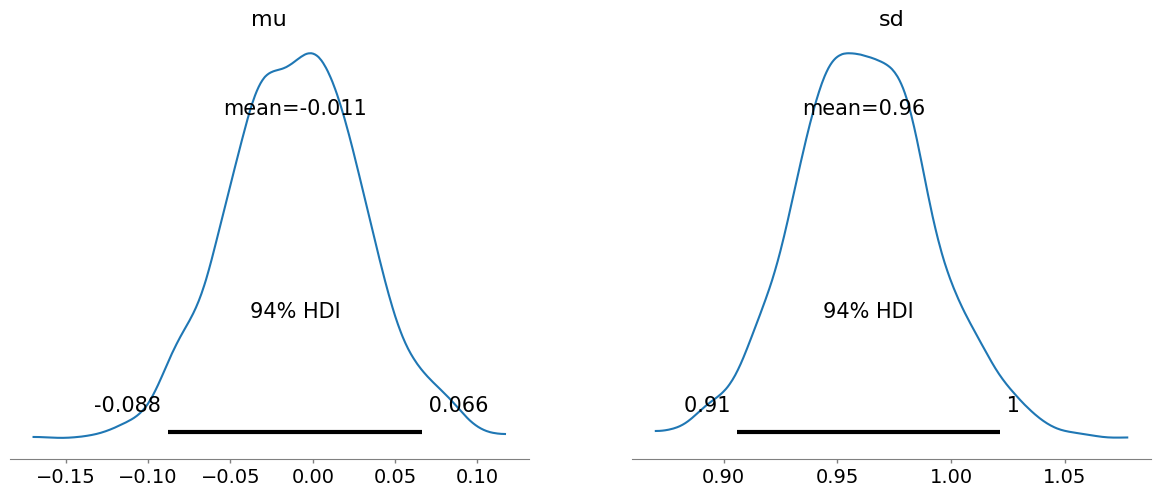

In [17]:
az.plot_posterior(posterior_samples);

## Prediction
Once the posterior distribution has been estimated, it can be used to compute predictions on new samples.

In [18]:
with model:
    posterior_samples.extend(pm.sample_posterior_predictive(posterior_samples, random_seed=rng))

Output()

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


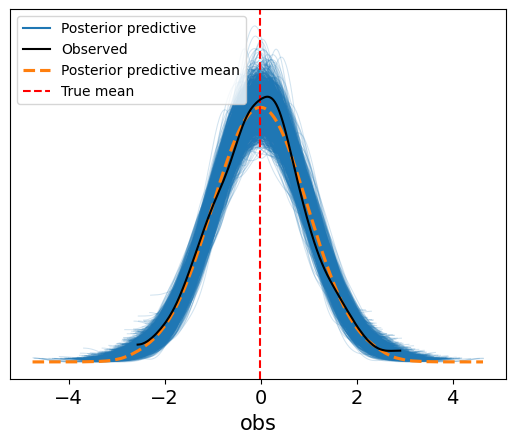

In [19]:
fig, ax = plt.subplots()
az.plot_ppc(posterior_samples, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

## Linear Regression
We consider a simple Bayesian linear regression model with normally distributed priors for the parameters. We are interested in predicting outcomes (Y) as normally distributed observations with an expected value ($\mu$) that is a linear function of two predictor variables,  ($X_1$) and ($X_2$):

$$
\begin{aligned}
Y  &\sim N(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}
$$

where ($\alpha$) is the intercept, ($\beta_i$) is the coefficient for covariate ($X_i$), and ($\sigma$) represents the observation error.

Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for ($\sigma$).

$$
\begin{aligned}
\alpha &\sim N(0, 100) \\
\beta_i &\sim N(0, 100) \\
\sigma &\sim \lvert N(0, 1)\rvert
\end{aligned}
$$


To start, we create a simulated dataset compliant with our model.

In [20]:
# True parameter values
alpha, sigma = 2, 1
beta = 3

# Size of dataset
train_size = 200

# Predictor variable
x = rng.normal(size=train_size)

# Simulate outcome variable
y = alpha + beta * x + rng.normal(size=train_size) * sigma

Then, we visualize the relationship between the variables.

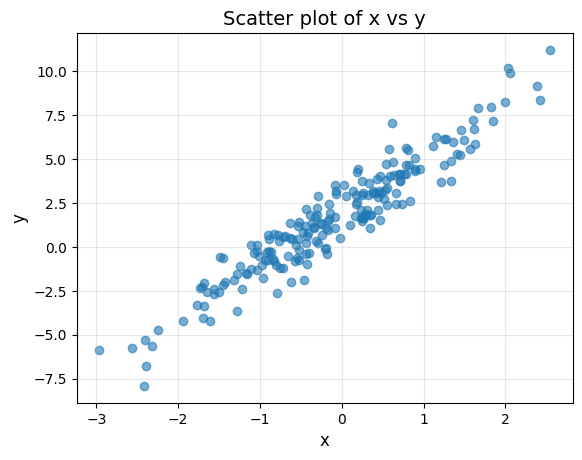

In [21]:
plt.scatter(x, y, alpha=0.6)
plt.title("Scatter plot of x vs y", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Then, we build the model specification.

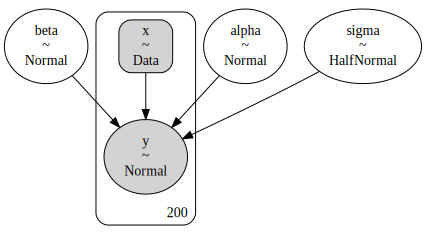

In [22]:
with pm.Model() as linear_model:
    # Priors for unknown model parameters
    alpha_rv = pm.Normal("alpha", mu=0, sigma=10)
    beta_rv = pm.Normal("beta", mu=0, sigma=10)
    sigma_rv = pm.HalfNormal("sigma", sigma=1)

    x_data = pm.Data("x", x.tolist())

    # Expected value of outcome
    mu = alpha_rv + beta_rv * x_data

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal("y", mu=mu, sigma=sigma_rv, observed=y, shape=x_data.shape)

pm.model_to_graphviz(linear_model)

Now, let's sample the posterior distributions of the parameter.

In [23]:
with linear_model:
    posterior_samples = pm.sample(return_inferecedata=True, random_seed=rng)

posterior_samples

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Feel free to explore the `idata` object, checking out its attributes, or to sample and plot the priors as we did before.

Let's visualize the posterior distributions.

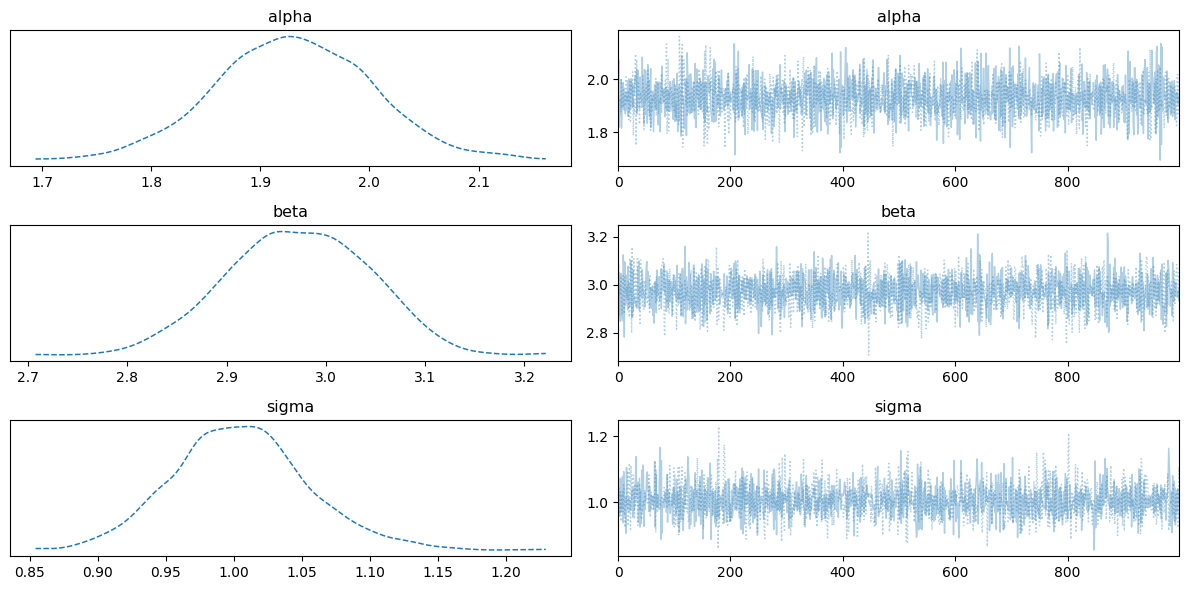

In [24]:
az.plot_trace(posterior_samples, combined=True)
plt.tight_layout()
plt.show()

In [25]:
az.summary(posterior_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.930,0.071,1.789,2.055,0.001,0.002,3574.0,1760.0,1.0
beta,2.972,0.071,2.835,3.093,0.001,0.002,3329.0,1543.0,1.0
sigma,1.005,0.050,0.913,1.101,0.001,0.001,2731.0,1520.0,1.0


Remember: the priors were highly uninformative, so it is not obvious to get posteriors so close to the true values.

Let's try and draw some inference from new data.

In [26]:
test_size = 50

test_x = rng.normal(size=test_size)

with linear_model:
    pm.set_data({"x": test_x.tolist()})
    prediction_trace = pm.sample_posterior_predictive(
        posterior_samples,
        var_names=["y"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )
    predictions_mean = prediction_trace["predictions"]["y"][1].mean(axis=0)
    prediction_intervals = az.hdi(ary=prediction_trace["predictions"], hdi_prob=0.95)["y"]
    prediction_df = pd.DataFrame(
        {
            "x": test_x,
            "y": alpha + beta * test_x + rng.normal(size=test_size) * sigma,
            "prediction_mean": predictions_mean,
            "prediction_hdi_5": prediction_intervals[:, 0],
            "prediction_hdi_95": prediction_intervals[:, 1],
        }
    )

prediction_df.head()

Output()

,x,y,prediction_mean,prediction_hdi_5,prediction_hdi_95
0,0.102553,2.785189,2.212091,0.344236,4.232218
1,-0.147442,0.395244,1.566199,-0.477879,3.534178
2,1.588276,6.052726,6.655553,4.673439,8.667134
3,-0.622207,1.503919,0.093012,-1.872366,2.101493
4,2.060298,7.696864,8.049364,6.120821,10.086452


And now let's visualize the predictions, with their confidence interval.

As we are sampling the full posterior distribution of the paramters, the predictions are themselves fully probabilistic, meaning we get a probability distribution for each predicted sample.

In the chart, we only represent the mean, and the 5th and the 95th percentile.

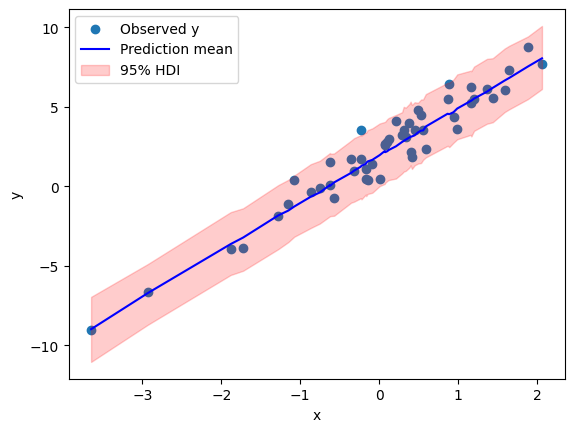

In [27]:
prediction_df = prediction_df.sort_values("x")

plt.figure()
plt.scatter(prediction_df["x"], prediction_df["y"], label="Observed y")
plt.plot(
    prediction_df["x"],
    prediction_df["prediction_mean"],
    label="Prediction mean",
    color="blue",
)
plt.fill_between(
    prediction_df["x"],
    prediction_df["prediction_hdi_5"],
    prediction_df["prediction_hdi_95"],
    color="red",
    alpha=0.2,
    label="95% HDI",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()